In [1]:
import numpy as npp
import minpy.numpy as np
import cPickle
import matplotlib.pyplot as plt
import minpy
minpy.set_global_policy('only_numpy')

from SimplePolicyNetwork import SimplePolicyNetwork
from SimpleRLPolicyGradientSolver import SimpleRLPolicyGradientSolver
from simpleBox import simpleBox
from SimRat import SimRat
from dataProcessFunctions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MySQLdb not found
Using mysql.connector


In [2]:
weight_file = "good_weights/good_weights"
loaded_params = load_weights(weight_file+"4.pkl")

Episode 100 complete (0.01s), loss: 19.3033824104, reward: 2, running reward: 0.858877549946
Episode 200 complete (0.01s), loss: -0.0792745950031, reward: 0, running reward: 1.32540554946
Episode 300 complete (0.01s), loss: 16.3260739706, reward: 4, running reward: 1.76569657991
Episode 400 complete (0.01s), loss: 3.50472063628, reward: 2, running reward: 2.09285295273
Episode 500 complete (0.01s), loss: 2.33297715885, reward: 4, running reward: 2.44713311801
Episode 600 complete (0.01s), loss: 2.59500449336, reward: 4, running reward: 2.81488925779
Episode 700 complete (0.01s), loss: 1.12840480507, reward: 4, running reward: 3.02255065159
Episode 800 complete (0.01s), loss: 1.23609988127, reward: 4, running reward: 3.22523180004
Episode 900 complete (0.01s), loss: 0.637803424982, reward: 4, running reward: 3.28817689001
Episode 100 complete (0.01s), loss: 8.35971157367, reward: 4, running reward: 0.726988746704
Episode 200 complete (0.01s), loss: 10.9352065531, reward: 2, running rewa

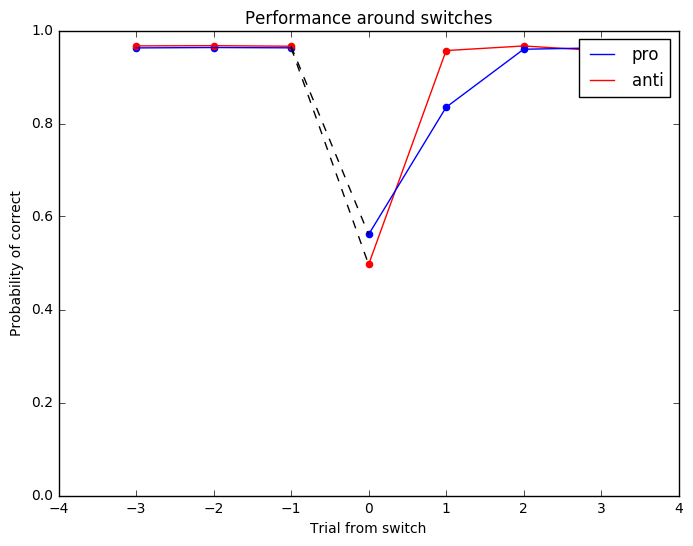

In [27]:
box = simpleBox(mode="alternative",length=10000,block_size=30,random_range=0,trial_per_episode=5, repeat = True)
val_X, val_y = box.X,box.y
rats = {}
for i in range(5):
    model = SimplePolicyNetwork(hidden_dim=5,reg=0, noise_factor = 0)
    box = simpleBox(mode="pro_only",length=10000,block_size=100,random_range=0,
                    trial_per_episode=5, repeat = True, reward_ratio = 1)
    solver = SimpleRLPolicyGradientSolver(model, box,
                                        update_rule='adam',
                                        optim_config={
                                            'learning_rate': 0.01,
                                            'decay_rate': 1
                                        },
                                        init_rule='xavier',
                                        num_episodes=50,
                                        verbose=False,
                                        supervised = False,
                                        print_every=100)
    solver.load_params(loaded_params)
    solver.train()

    box.change_mode("anti_only")
    solver.change_settings(learning_rate=0.01,num_episodes=50)
    solver.train()

    box.change_mode("alternative")
    solver.change_settings(learning_rate=0.01,num_episodes=1000)
    solver.train()
    
    rat = SimRat(model)
    probs = rat.predict(val_X,val_y, noise=0)
    ratname = 'VirtualRat'+str(i)
    rats[ratname] = rat
    
trial_window = 3
p2a_mean, a2p_mean = meanPerformance(rats, trial_window = 3)
np.set_printoptions(precision=2)
plt.ylim([0,1])
draw_3d(p2a_mean, a2p_mean, trial_window = 3)

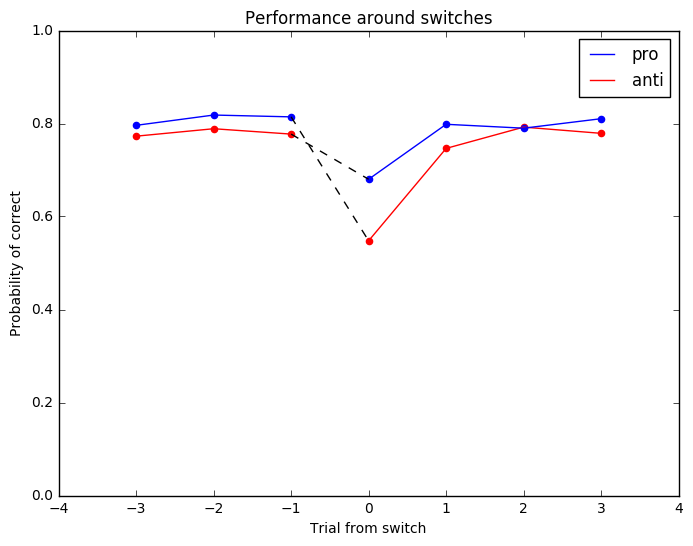

In [30]:
for ratname, rat in rats.iteritems():
    probs = rat.predict(val_X,val_y, noise=1)
trial_window = 3
p2a_mean, a2p_mean = meanPerformance(rats, trial_window = 3)
np.set_printoptions(precision=2)
plt.ylim([0,1])
draw_3d(p2a_mean, a2p_mean, trial_window = 3)

In [ ]:
# Code for generating good intial parameters.
init_params = []
for i in range(30):
    print
    print "Number %d" % (i,)
    model = SimplePolicyNetwork(hidden_dim=5,reg=0)
    box = simpleBox(mode="pro_only",length=50000,block_size=30,random_range=0,trial_per_episode=5,
                    repeat = True, reward_ratio = 5)
    solver = SimpleRLPolicyGradientSolver(model, box,
                                        update_rule='adam',
                                        optim_config={
                                            'learning_rate': 0.01,
                                            'decay_rate': 1
                                        },
                                        init_rule='xavier',
                                        num_episodes=50,
                                        verbose=False,
                                        supervised = False,
                                        print_every=100)
    solver.init()
    init_params.append(solver.save_params())
    solver.train()

    box.change_mode("anti_only")
    solver.change_settings(learning_rate=0.01,num_episodes=50)
    solver.train()

    box.change_mode("alternative")
    solver.change_settings(learning_rate=0.01,num_episodes=2000)
    solver.train()

    solver.change_settings(learning_rate=0.005,num_episodes=1000)
    solver.train()
    
    rat = SimRat(model)
    box.change_mode("alternative")
    probs = rat.predict(box.X,box.y)
    ratname = 'VirtualRat'
    loss_history(solver, ratname)
    sample_probabilities(probs, ratname, sample = 100)
    sample_correct_rate(rat, sample = 100)
    trial_window = 3
    np.set_printoptions(precision=2)
    plt.ylim([0,1])
    draw_3d(rat.p2a_prob, rat.a2p_prob, trial_window = 3)

In [ ]:
weight_file = "good_weights/good_weights"
suffix = ".pkl"
good_list = []
i=0
for index in good_list:
    i+=1
    save_weights(weight_file+str(i)+suffix, init_params[index])